<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Calibrating the F test for spectral peaks</h1>
<h2>Does power have one or two DOF's per frequency?</h2>
<h3>Brian Mapes, spring 2020</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#spectrum">Specify white spectrum, make a very long series</a>
1. <a href="#chopchop">Chop into segments and compute their pow(freqs) spectra</a>
1. <a href="#peak5">Find the 5th highest peak</a>
1. <a href="#results">RESULTS: the answer is 2 DOFs</a>

--------

# The question

#### If the power spectrum is only half the information content of the input data, does it really count as 2 pieces of information (squared amplitude of sine component plus squared amplitude of cosine component)? Or is it just 1 DOF? (squared amplitude; phase information is half the information content and is discarded)

# The Plan
### 1. make long realization of white time series (amplitude 1 for clarity) 
### 2. fft segments of that realization to make power spectrum P(f)
### 3. For each realization, find the argument and value of the 5th percentile peak
### 4. Compare those values (ratio over 1) to F(1,inf) and F(2,inf)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.xkcd() # whiteboard style, informal looking

<matplotlib.pyplot.xkcd.<locals>.dummy_ctx at 0x104583f60>

----------------
<a name="spectrum"></a>
### White spectrum exactly, make a long long realization

In [3]:
NT = 10000
AMP = 1. 
ampli = AMP + zeros(NT)
ampli[0] = 0 # make the series have zero time-mean
power = ampli**2 

## Synthesize data w/ known P(f), random phase. 
#### Notice that 1j is *i* in Python 

In [4]:
# Phase = rand() makes synthetic data w/ uniform distribution
phase = 2*pi*rand( len(ampli) )

In [15]:
# Build the synthetic spectrum from real and imaginary parts
spec =  (    ampli*cos(phase)   #real part
       - 1j* ampli*sin(phase) ) #imag part

# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# there's a very-near-zero imaginary part; strip it off with real()
data = real( ifft(spec)* sqrt(NT) ) 

Text(0.5,1,'variance 0.9949548173338276')

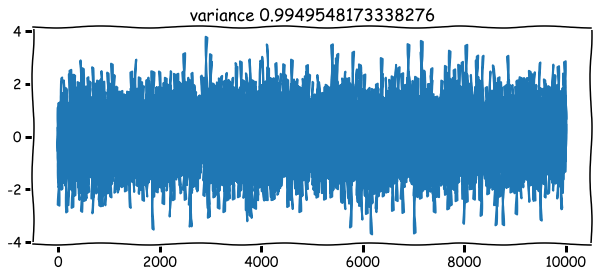

In [16]:
figsize(10,4)
data = data*sqrt(2) # to make variance unity, fft's quirks
plot(data); title('variance '+str(var(data)))

------------
<a name='chopchop'></a>
# Chop segments and make their P(f) 
### segpow will be power for the positive-f half of the symmetric spectrum

In [7]:
NTseg = 200 # length of segment

# Define positive half of the frequencies "freqs" 
freqs = np.array(range(NTseg//2))  

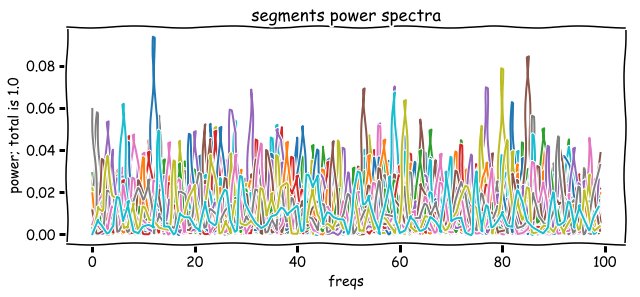

In [8]:
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
    plot(freqs[0:NTseg//2],segpow[0:NTseg//2]); title('segments power spectra')
    xlabel('freqs'); ylabel('power; total is '+str(AMP**2))
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))

------------

<a name='peak5'></a>
# For each segment
## find ratio of top 5 %ile segment power above analytic value
### To compare to the F test 

In [9]:
# Analytic power spectrum is total variance over NTseg/2 bins
analyticpow = AMP**2 / (NTseg/2)
analyticpow

0.01

Text(0.5,0,'frequency')

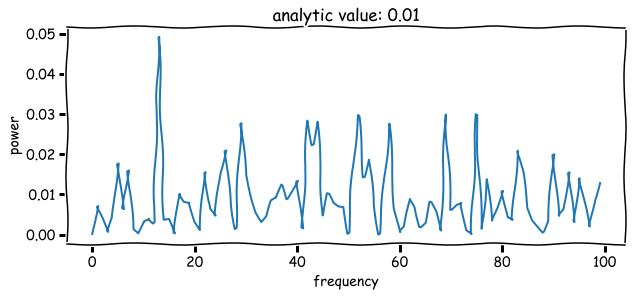

In [10]:
# example, last segment from previous loop 
plot(freqs[0:NTseg//2],segpow[0:NTseg//2] )
title('analytic value: '+str(analyticpow))
ylabel('power'); xlabel('frequency')

In [11]:
# Dividing by 20 gets you the 5th percentile 
NTseg//2//20 

5

------------

<a name='results'></a>
# Which is closer? 
#### F(2,inf) for p=0.05 is 3.07, vs. 3.92 for F(1,inf)
#### F(inf,2) for p=0.05 is 19.49, vs. 254.3 for F(inf,1)
from [here](http://www.socr.ucla.edu/Applets.dir/F_Table.html#FTable0.05)
# Answer: clearly, 2 DOFs

In [12]:
# one random sample, from the end of above loop
ratio = segpow[0:NTseg//2] / analyticpow
argsorted = argsort(ratio)
valsorted = sort(ratio)
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
print(valsorted[-NTseg//2//20])

95th %ile peak ratio to analytic: 3.1 or 3.9? 
2.8338414898403483


In [13]:
# Loop over segments and get the mean result 
res95 = [3.1]
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(      valsorted[-NTseg//2//20])
    res95.append(valsorted[-NTseg//2//20])
    
print('mean result '+str(mean(res95[1:])))

95th %ile peak ratio to analytic: 3.1 or 3.9? 
3.039605387360769
2.6353500158041614
3.5575936277448497
3.091995368130332
2.1802012497603807
2.507797646562574
3.0067494023380985
3.013895345149557
2.5093833771476217
3.362838291542246
2.527370064996739
3.363055214981314
2.768974184158537
3.2367254283475266
3.6081813750035474
3.5857107360378864
2.579752410673588
2.670778863603956
2.966245452027416
3.6823082461090806
3.8262196825984707
2.8020097294170117
3.6921586627001712
2.746732057993588
2.7693514336832155
2.499621787594591
2.916033967783462
2.3089873362658384
3.9465311293561114
3.1045036393514325
3.633790644372649
3.083021015595654
2.6506991993716094
3.456106087050765
4.795565050501508
3.5701955770609075
2.900789395392085
2.7884725454899266
3.4942415079937805
2.915255329820515
3.6395770597104833
3.4148898419029785
3.1735578571498015
2.5318699300621503
3.0431900865117822
3.1363700330881605
2.6002110302920136
2.6212367913574868
3.5054699504975293
2.8338414898403483
mean result 3.085900230

In [14]:
print('5th %ile peak ratio to analytic (inverse): 19.5 or 254? ')
res5 = [19.]
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(  str(1.0/valsorted[NTseg//2//20])+' at freq '+str(argsorted[NTseg//2//20]))
    res5.append(1.0/valsorted[NTseg//2//20])
    
print('mean result '+str(mean(res5[1:])))

5th %ile peak ratio to analytic (inverse): 19.5 or 254? 
15.312737940426842 at freq 99
22.343390300796425 at freq 28
20.1179476309544 at freq 35
15.45024812285802 at freq 68
17.50752352507017 at freq 59
34.8069927888714 at freq 66
25.845004880019477 at freq 28
9.052076262655802 at freq 65
17.422717637653417 at freq 59
14.112235298741846 at freq 25
14.108125865612802 at freq 12
23.44510349578828 at freq 87
15.16674738277987 at freq 69
20.008840011497103 at freq 58
13.930341448122883 at freq 29
12.552811420065941 at freq 89
15.120591619983507 at freq 26
48.02942470192332 at freq 9
14.5603250628345 at freq 69
22.310538779480396 at freq 9
23.928007589233307 at freq 60
23.857105891332107 at freq 50
17.28856894126212 at freq 10
20.899595594527657 at freq 87
14.487566727057974 at freq 68
13.060584887272999 at freq 72
16.489890612251237 at freq 43
9.962275311948932 at freq 80
12.947006966895199 at freq 85
21.816676169276672 at freq 80
13.551157750465691 at freq 52
11.945919504262525 at freq 80